In [1]:
%matplotlib notebook

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

<hr style="border-width:4px; border-color:coral"/>

# Set example

<hr style="border-width:4px; border-color:coral"/>

In [3]:
ex_list = ['star_center_08', 'star_center_32', 'star_center_64']

example = ex_list[2]

<hr style="border-width:4px; border-color:coral"/>

# Data Tools (file)

<hr style="border-width:4px; border-color:coral"/>

In [4]:
%%file data_tools.py
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

import sys

cmap = plt.get_cmap('tab20').colors

amr_colors = {'advance' : (cmap[0:2]),     # blue
              'ghost'   : (cmap[2:4]),     # orange
              'regrid'  : (cmap[4:6]),     # green
              'comm'    : (cmap[6:8]),     # red
              'memcopy' : (cmap[8:10]),    # purple
              'other'   : (cmap[10:12]),   # brown
              'extra1'  : (cmap[12:14]),   # pink
              'extra2'  : (cmap[14:16]),   # grey
              'extra3'  : (cmap[16:18]),   # light green
              'extra4'  : (cmap[18:20])}   # tourquoise
  
Int_type = pandas.Int32Dtype()  # Use this extended type if data contains Nans
int_type = 'int32'
float_type = 'float'
o_type = 'object'

dtypes = {'walltime': float_type,
          'ell_solve' : float_type,
          'max' : Int_type,
          'mx' : Int_type,
          'ell_grids' : Int_type,
          '1-norm' : float_type,
          '2-norm' : float_type,
          'inf-norm' : float_type,
          'itcount' : Int_type}


def read_data(dir,ex,mesh,solver):
    fname_results = os.path.join('{:s}'.format(dir),
                         '{:s}'.format(ex),
                         '{:s}'.format(mesh),
                         '{:s}'.format(solver),
                         'results.out')
    # Read errors
    fname_errors = os.path.join('{:s}'.format(dir),
                         '{:s}'.format(ex),
                         '{:s}'.format(mesh),
                         '{:s}'.format(solver),
                         'errors.dat')        
        
    try:
        df = pandas.read_table(fname_results,delim_whitespace=True)
        print("Reading '{:s}'".format(fname_results))
        try:
            df_errors = pandas.read_table(fname_errors,delim_whitespace=True)
        except:
            print("Not able to read '{:s}'".format(fname_errors))
            sys.exit()
    except:
        print("No file '{:s}'".format(fname_results))
        df = None
        fstr = ''
        return df,fstr
        
    # Add a column for effective resolution
    df['eff_res'] = df['mx']*2**df['max']
    df.sort_values('eff_res',inplace=True)
    
    df['1-norm'] = df_errors['1-norm'].values
    df['2-norm'] = df_errors['2-norm'].values
    df['inf-norm'] = df_errors['inf-norm'].values
    df['itcount'] = (df_errors['itcount'].values).astype(int)


    # Int values are commented out - any NaNs cannot be formatted as an
    # integer type
    f = '{:.2f}'.format
    int_format = '{:.0f}'.format
    fstr = {'p' : int_format,
            'mx' : int_format,  # Needed to avoid Nans
            'max' : int_format,
            'walltime' : f,
            'ell_solve' : f,
            '1-norm' : '{:.2e}'.format,
            '2-norm' : '{:.2e}'.format,
            'inf-norm' : '{:.2e}'.format,
            'itcount' : int_format,
            'eff_res' : int_format,
            'ell_grids' : int_format,
            'grids_proc' : int_format}
    
    return df,fstr

def convergence_rates(df,field=['1-norm','2-norm','inf-norm'],I=None):
    Neff = df.index.get_level_values(0).values
    for f in field:
        y = df[f].values

        # Plot best-fit speed-up line
        t_errors = np.array(df[f].values)
        if I is None:
            c = np.polyfit(np.log(Neff[:-1]),np.log(t_errors[:-1]),1)
        else:
            c = np.polyfit(np.log(Neff[I[0]:I[1]+1]),np.log(t_errors[I[0]:I[1]+1]),1)

        plt.loglog(Neff,y,'.-',markersize=15,label='{:s} (slope={:6.2f})'.format(f,c[0]))            
        plt.loglog(Neff,np.exp(np.polyval(c,np.log(Neff))),'k-',linewidth=1)

    p0 = np.log2(Neff[0])
    p1 = np.log2(Neff[-1])
    plt.xlim([2**(p0-1), 2**(p1+1)])
    
    Nstr = (['{:d}'.format(int(N)) for N in Neff])
    plt.xticks(Neff,Nstr)
        
    plt.legend()
    plt.show()
    

def iteration_count_plot(df,I=None):
    Neff = df.index.get_level_values(2).values
    for f in ['single','uniform','adapt']:
        y = df[f].values

        # Plot best-fit speed-up line
        t_itcount = np.array(df[f].values).astype(float)
        if I is None:
            c = np.polyfit(np.log(Neff[:-1]),np.log(t_itcount[:-1]),1)
        else:
            c = np.polyfit(np.log(Neff[I[0]:I[1]+1]),np.log(t_itcount[I[0]:I[1]+1]),1)

        plt.loglog(Neff,y,'.-',markersize=15,label='{:s} (slope={:6.2f})'.format(f,c[0]))            
        plt.loglog(Neff,np.exp(np.polyval(c,np.log(Neff))),'k-',linewidth=1)
        #c[0] = -2
        #plt.loglog(Neff,np.exp(np.polyval(c,np.log(Neff))),'k--',label='Theoretical',linewidth=0.5)

    p0 = np.log2(Neff[0])
    p1 = np.log2(Neff[-1])
    plt.xlim([2**(p0-1), 2**(p1+1)])
    
    Nstr = (['{:d}'.format(int(N)) for N in Neff])
    plt.xticks(Neff,Nstr)
    
    ax = plt.gca()
    ax.set_ylabel('Iteration Count')
    ax.set_xlabel('Effective Resolution')
    
    plt.legend()
    plt.show()
    
def iteration_count_barplot(df):
    Neff = df.index.get_level_values(2).values
    for f in ['single','uniform','adapt']:
        y = df[f].values

        # Plot best-fit speed-up line
        t_itcount = np.array(df[f].values).astype(float)
        if I is None:
            c = np.polyfit(np.log(Neff[:-1]),np.log(t_itcount[:-1]),1)
        else:
            c = np.polyfit(np.log(Neff[I[0]:I[1]+1]),np.log(t_itcount[I[0]:I[1]+1]),1)

        plt.loglog(Neff,y,'.-',markersize=15,label='{:s} (slope={:6.2f})'.format(f,c[0]))            
        plt.loglog(Neff,np.exp(np.polyval(c,np.log(Neff))),'k-',linewidth=1)
        #c[0] = -2
        #plt.loglog(Neff,np.exp(np.polyval(c,np.log(Neff))),'k--',label='Theoretical',linewidth=0.5)

    ax = df_plot.plot.barh(width=0.75)
    p0 = np.log2(Neff[0])
    p1 = np.log2(Neff[-1])
    plt.xlim([2**(p0-1), 2**(p1+1)])
    
    Nstr = (['{:d}'.format(int(N)) for N in Neff])
    plt.xticks(Neff,Nstr)
    
    ax = plt.gca()
    ax.set_ylabel('Iteration Count')
    ax.set_xlabel('Effective Resolution')
    
    plt.legend()
    plt.show()


    
def time_per_grid(df,field='walltime'):
 
    # Efficiency
    procs = df.index.get_level_values(0).values
    T0 = df[field][1]   # Processor 1
    S = T0/df[field]
    E = 100*S/procs

    plt.semilogx(procs,E,'.-',markersize=15)
    plt.semilogx(procs,[100]*len(procs),'k--',linewidth=2)

    plt.xlabel('Cores',fontsize=16)
    plt.ylabel('Efficiency (%)',fontsize=16)
    plt.title("Efficiency (%)");
    plt.legend(['Time (s)', 'Perfect efficiency'])
    p0 = np.log2(procs[0])
    p1 = np.log2(procs[-1])
    plt.xlim([2**(p0-1), 2**(p1+1)])
    
    pstr = ([str(p) for p in procs])
    plt.xticks(procs,pstr)

    plt.ylim([10,110])
    plt.grid()
    plt.show()
    
def bar_plot(df_in):
    
    Neff = df_in.index.get_level_values(2).values

    df_plot = df_in.copy()
    c = []
    for N in Neff:
        c += ['Neff {:d}'.format(N.astype(int))]        
    #df_plot.columns = reversed(c)

    # ------------------------ Plotting command --------------------------
    ax = df_plot.plot.barh(width=0.75)
    plt.xlabel('Time (seconds)');

    # --------------- Post-processing (legend, axis tick marks) ----------
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='lower right')

    # ax.xaxis.set_major_locator(plt.MultipleLocator(10))   # Multiples of 10  (seconds)
    # ax.xaxis.set_minor_locator(plt.MultipleLocator(5))   # Multiples of 5 (seconds)
    # ax.xaxis.set_major_formatter(plt.FixedFormatter(lambda value,tick_number : '{:.2f}'.format(value)))

    ax.set_yticklabels(Neff)
    ax.set_ylabel('Effective Resolution')
    ax.set_xscale('log')
    
    plt.grid()
    # plt.xlim([0,135]);
    plt.show()    
    
def barh_plot(df_in):
    
    Neff = df_in.index.get_level_values(0).values

    df = df_in.copy()
    # -------------------------- Pre-processing ----------------------------
    # df['ghost'] = df['ghostfill'] + df['patch_comm']
    #df['Other'] = df['walltime'] - df['advance'] - df['ghostfill'] - df['patch_comm'] \
    #        -df['adapt']-df['regrid']-df['output']


    # di = {'advance' : 'Advance', 'ghost' : 'Ghost'}

    # For plotting (iloc[::-1] reverses order of the rows)
    df_plot = df.iloc[::-1].copy()
    df_plot = df
    c = []
    for N in Neff:
        c += ['Eff. Res. {:d} '.format(N)]
    df_plot.index = reversed(c)
    
    # -------------------------- Plotting command -------------------------
    ax = df_plot.plot.barh(width=0.85,stacked=True)
    
    plt.xlabel('Time (seconds)');

    # --------------------------- Post-processing -------------------------
    handles, labels = ax.get_legend_handles_labels()
    # ax.legend(reversed(handles), reversed(labels), loc='lower right')

    ax.xaxis.set_major_locator(plt.MultipleLocator(10))   # Multiples of 60 (minutes)
    ax.xaxis.set_minor_locator(plt.MultipleLocator(5))   # Multiples of 60 (minutes)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number : '{:.2f}'.format(value/60)))

    plt.grid()
    # plt.xlim([0,100]);
    plt.show()    
    


Overwriting data_tools.py


<hr style="border-width:4px; border-color:coral"/>

# Read data and set up Pandas MultiIndex

<hr style="border-width:4px; border-color:coral"/>

In [22]:
import data_tools
import os

idx = pandas.IndexSlice

cols = ['mx','max','walltime','ell_solve','ell_grids','1-norm','2-norm','inf-norm','itcount'];

mesh = ['single','uniform','adapt']
patch_solver = ['VC']
eff_res = [32,64,128,256,512,1024, 2048,4096]

iterables = [ex_list, mesh,patch_solver,eff_res]

index = pandas.MultiIndex.from_product(iterables,names=['example','mesh',
                                                        'patch-solver','eff_res'])
df = pandas.DataFrame(index=index,columns=cols).sort_index()

#ex_data = {}
dir = 'timing_data'
for ex in ex_list:
    for m in mesh:
        for s in patch_solver:
            dft,fstr = data_tools.read_data(dir,ex,m,s)            
            if dft is not None:
                l = dft['eff_res']
                df.loc[idx[ex,m,s,l],:] = dft[cols].values
    
df.index.name = 'eff_res'
for col, dtype in data_tools.dtypes.items():
    try:
        df[col] = df[col].astype(dtype)
    except:
        print('Not setting {:s} to {:s}'.format(col,dtype))
        pass

# example_data = df.transpose().unstack(level=2).stack(level=0)
example_data = df
df

No file 'timing_data/star_center_08/single/VC/results.out'
Reading 'timing_data/star_center_08/uniform/VC/results.out'
Reading 'timing_data/star_center_08/adapt/VC/results.out'
Reading 'timing_data/star_center_32/single/VC/results.out'
Reading 'timing_data/star_center_32/uniform/VC/results.out'
Reading 'timing_data/star_center_32/adapt/VC/results.out'
No file 'timing_data/star_center_64/single/VC/results.out'
Reading 'timing_data/star_center_64/uniform/VC/results.out'
Reading 'timing_data/star_center_64/adapt/VC/results.out'


mx  max     walltime  \
example        mesh    patch-solver eff_res                         
star_center_08 adapt   VC           32        8    2      0.19946   
                                    64        8    3      1.24180   
                                    128       8    4      7.29940   
                                    256       8    5     48.81600   
                                    512       8    6    268.29000   
...                                          ..  ...          ...   
star_center_64 uniform VC           256      64    2      1.91240   
                                    512      64    3     15.85500   
                                    1024     64    4    116.61000   
                                    2048     64    5   1174.00000   
                                    4096     64    6  22923.00000   

                                               ell_solve  ell_grids  \
example        mesh    patch-solver eff_res                           
star_center_08 adapt   VC           32           0.18118         16   
                                    64           1.19370         52   
                                    128          7.17180        148   
                                    256         48.44100        496   
                                    512        267.22000       1456   
...                                                  ...        ...   
star_center_64 uniform VC           256          1.71100         16   
                                    512         15.05400         64   
                                    1024       113.47000        256   
                                    2048      1161.50000       1024   
                                    4096     22813.00000       4096   

                                                1-norm     2-norm   inf-norm  \
example        mesh    patch-solver eff_res                                    
star_center_08 adapt   VC           32        2.117800   3.081700  14.417000   
                                    64       22.834000  30.992000  82.068000   
                                    128       7.488200  10.203000  29.308000   
                                    256       0.082251   0.118770   0.669960   
                                    512       0.002685   0.003776   0.030621   
...                                                ...        ...        ...   
star_center_64 uniform VC           256       0.082243   0.118770   0.669950   
                                    512       0.002684   0.003776   0.030620   
                                    1024      0.000050   0.000305   0.005327   
                                    2048      0.000012   0.000075   0.001302   
                                    4096      0.000003   0.000019   0.000324   

                                             itcount  
example        mesh    patch-solver eff_res           
star_center_08 adapt   VC           32            57  
                                    64           131  
                                    128          270  
                                    256          545  
                                    512         1008  
...                                              ...  
star_center_64 uniform VC           256          430  
                                    512          901  
                                    1024        1651  
                                    2048        4146  
                                    4096       19685  

[72 rows x 9 columns]

<hr style="border-width:4px; border-color:coral"/>

# Practice using a MultiIndex table

<hr style="border-width:4px; border-color:coral"/>

In [ ]:
# Extract all of the data for one example

example_data.loc['star_center_32'].style.format(fstr)

In [ ]:
# Extract only the 'uniform' mesh results for a particular example

df_uni = example_data.loc[(example,'uniform','VC'),:]
df_uni.style.format(fstr)

In [19]:
# Extract subset of columns for one example

df_uni = example_data.loc[idx['star_center_32',:,'VC',:],['max','mx','ell_solve','inf-norm']]
df_uni.style.format(fstr)


In [ ]:
# Extract all results at effective resolution 256 and 512

example_data.loc[idx[example,:,'VC',(256,512)],:]


In [ ]:
# Extract data for one solver type ('VC') and display time for elliptic solve side-by-side

df_mesh = example_data.loc[idx[:,:,'VC',:],'ell_solve']
# unstack level is the level that should be side by side
cols = ['single','uniform','adapt']
df_mesh.unstack(level=1)[cols].style.format('{:.2e}'.format)

In [ ]:
# Extract data for one solver type ('VC') and display time for elliptic solve side-by-side

df_mesh = example_data.loc[idx['star_center_32',:,'VC',:],'itcount']
# unstack level is the level that should be side by side
cols = ['single','uniform','adapt']
df_mesh.unstack(level=1)[cols]

In [ ]:
# Display with effective resolution across the top

idx = pandas.IndexSlice
cols = ['single','uniform','adapt']
df_effres = example_data.loc[idx[example,:,'VC'],('1-norm')]
# df_effres.unstack().style.format('{:.4e}'.format)
df_effres.unstack().style.format('{:.2e}'.format)

In [ ]:
# Select series and extract values of data from individual run

idx = pandas.IndexSlice
s_adapt = example_data.loc[(example,'adapt','VC'),'ell_solve']
[s_adapt.index.values,s_adapt.values]

In [ ]:
# Display using different colors

idx = pandas.IndexSlice
eff_res = [64,128,256,512,1024,2048,4096]    # NaNs in 'adapt' simulation prevent 
df_time = example_data.loc[idx[example,['uniform','adapt'],'VC',eff_res],('ell_solve')].unstack(level=1)
df_time['uniform/adapt'] = (df_time['uniform']/df_time['adapt']).astype(float)
df_time.style.format('{:.2f}'.format)
df_time.style.format('{:.2f}'.format).background_gradient(subset=['uniform/adapt'],\
                                  cmap='YlOrBr',low=0.5,high=1)

In [ ]:
# Display using different colors

idx = pandas.IndexSlice
eff_res = [32,64,128,256,512,1024]    # NaNs in 'adapt' simulation prevent 
df_time = example_data.loc[idx['star_center_32',:,'VC',eff_res],('ell_solve')].unstack(level=1)
df_time['uniform/single'] = (df_time['uniform']/df_time['single']).astype(float)
df_time['adapt/single'] = (df_time['adapt']/df_time['single']).astype(float)
df_time.style.format('{:.2f}'.format)
df_time.style.format('{:.2f}'.format).background_gradient(subset=['uniform/single','adapt/single'],\
                                  cmap='YlOrBr',low=0.3,high=1)

In [ ]:
# Compare times for different patch sizes (8x8 vs. 32x32)

idx = pandas.IndexSlice
eff_res = [64,128,256,512,1024]    # NaNs in 'adapt' simulation prevent 
df_time = example_data.loc[idx[:,['uniform','adapt'],'VC',eff_res],('ell_solve')].unstack(level=0)
df_time['32/64'] = (df_time['star_center_32']/df_time['star_center_64']).astype(float)
df_time['8/64'] = (df_time['star_center_08']/df_time['star_center_64']).astype(float)

df_time.style.format('{:.2f}'.format)
df_time.style.format('{:.2f}'.format).background_gradient(subset=['32/64','8/64'],\
                                  cmap='YlOrBr',low=0.2,high=1)

<hr style="border-width:4px; border-color:coral"/>

# Convergence rates

<hr style="border-width:4px; border-color:coral"/>

Create data frame containing convergence rates. 

In [6]:
# Compute convergence rates for uniform method and put them into a data frame

ex = 'star_center_32'
mesh = 'adapt'
#eff_res = [64,128,256,512,1024,2048,4096] 

# Set up Data frame
idx = pandas.IndexSlice
df_rates = example_data.loc[idx[ex,mesh,'VC',:],
                          ['1-norm','2-norm','inf-norm']]

# use numpy arrays to create convergence rates
r1 = np.log2(df_rates['1-norm'].values[0:-1]/df_rates['1-norm'].values[1:])
r2 = np.log2(df_rates['2-norm'].values[0:-1]/df_rates['2-norm'].values[1:])
r3 = np.log2(df_rates['inf-norm'].values[0:-1]/df_rates['inf-norm'].values[1:])

# Add rates to data frame; pre-pend with Nan value
df_rates['rate (1)'] = np.insert(r1,0,np.nan)
df_rates['rate (2)'] = np.insert(r2,0,np.nan)
df_rates['rate (inf)'] = np.insert(r3,0,np.nan)

# Format columns of data frame
fstr = {}.fromkeys(['1-norm', '2-norm', 'inf-norm'], '{:.2e}'.format)
fstr.update(fstr.fromkeys(['rate (1)', 'rate (2)', 'rate (inf)'], '{:.2f}'.format))

# Display data frame
df_rates.style.format(fstr)

<IPython.core.display.Javascript object>


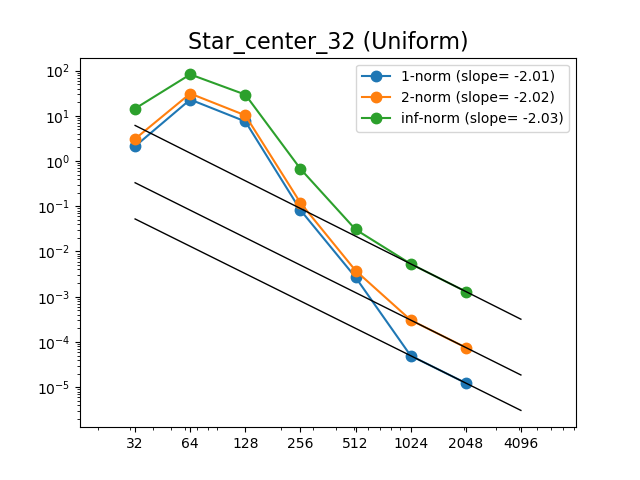

In [38]:
import data_tools

ex = 'star_center_32'
cols = ['1-norm','2-norm','inf-norm']

df_vc = example_data.loc[(ex,'adapt','VC'),cols]

plt = data_tools.plt

plt.figure()
data_tools.convergence_rates(df_vc,['1-norm','2-norm','inf-norm'],[5,6])
plt.title('{:s} (Uniform)'.format(ex.capitalize()),fontsize=16);

<hr style="border-width:4px; border-color:coral"/>

## Timing : Bar plot (VC)

<hr style="border-width:4px; border-color:coral"/>

<IPython.core.display.Javascript object>


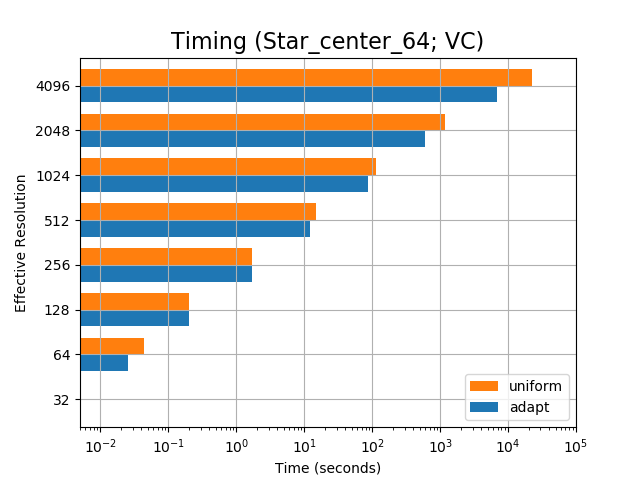

In [26]:
import data_tools
ex = 'star_center_64'
df_vc = example_data.loc[idx[ex,['uniform','adapt'],'VC',:],'ell_solve']
df_vc = pandas.DataFrame(df_vc.unstack(1))

h = data_tools.bar_plot(df_vc)

plt = data_tools.plt
# ax = plt.gca()
plt.title('Timing ({:s}; VC)'.format(ex.capitalize()),fontsize=16);

plt.xlim([5e-3,1e5]);


## Iteration count : Bar plot (VC)

In [98]:
import data_tools
df_vc = pandas.DataFrame(example_data.loc[idx[example,['adapt','uniform'],'VC',:],'itcount'])
df_vc = df_vc.unstack(0)
df_vc

itcount
example                      star_center_64
mesh    patch-solver eff_res               
adapt   VC           32                 NaN
                     64                 107
                     128                210
                     256                430
                     512                872
                     1024              2151
                     2048              4675
                     4096             18085
uniform VC           32                 NaN
                     64                 107
                     128                210
                     256                430
                     512                901
                     1024              1651
                     2048              4146
                     4096             19685

<IPython.core.display.Javascript object>


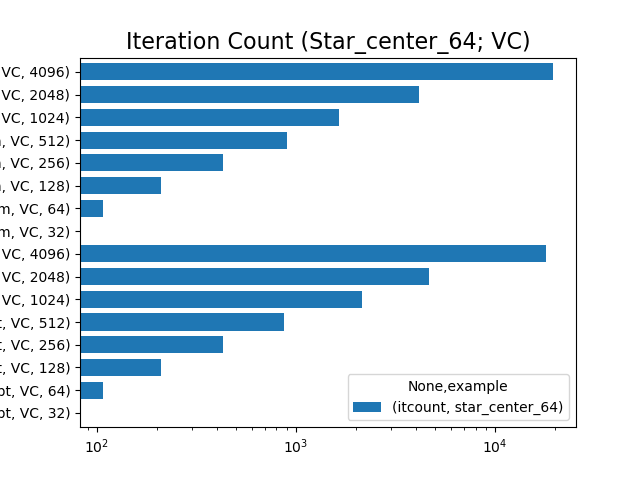

In [99]:
ax = df_vc.plot.barh(width=0.75)

ax.set_xscale('log')
ax.set_ylabel('Iteration Count')

data_tools.plt.title('Iteration Count ({:s}; VC)'.format(example.capitalize()),fontsize=16);

<hr style="border-width:4px; border-color:coral"/>

# Comparisons between patch sizes

<hr style="border-width:4px; border-color:coral"/>

<IPython.core.display.Javascript object>


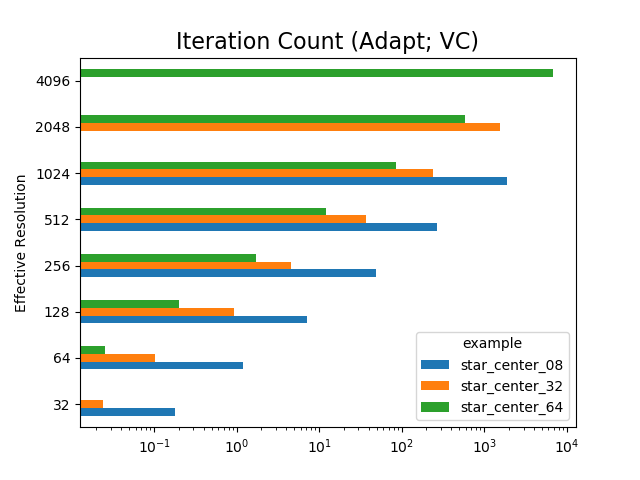

In [48]:
import data_tools
from data_tools import amr_colors

idx = pandas.IndexSlice

width = 0.375
d = 0.05

i0 = np.array([0,1,2,3,4])
i1 = list(reversed(i0 + (d + width)/2))
i2 = list(reversed(i0 - (d + width)/2))

ac = 1
ag = 1

# plt.grid(axis='x')


# ---------------------------------- bar plots ---------------------------------------

df_time = example_data.loc[idx[:,'adapt','VC',:],('ell_grids','itcount','ell_solve')]
df_time = df_time.unstack(0)  # .style.format({'ell_solve' : '{:.2f}'.format})
Neff = df_time.index.get_level_values(2).values

plt = df_time['ell_solve'].plot.barh()    # width,color=amr_colors['ghost'][0])

plt.set_yticklabels(Neff)
plt.set_ylabel('Effective Resolution')
plt.set_xscale('log')

plt.set_title('Iteration Count (Adapt; VC)',fontsize=16);

In [ ]:
# ---------------------------------- Tick marks, legend ---------------------------------------
plt = data_tools.plt
ax=data_tools.plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(5*60))   # Multiples of seconds
ax.xaxis.set_minor_locator(plt.MultipleLocator(2.5*60))   # Multiples of seconds
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number : '{:0.0f}'.format(value/60)))

ax.yaxis.set_major_locator(plt.FixedLocator(i0, nbins=None))
ax.set_yticklabels(reversed(['1 Proc','2 Procs','4 Procs','8 Procs','16 Procs']))

plt.title('{:s} example'.format(example.capitalize()))
plt.xlabel('Time (minutes)')
plt.legend()

plt.show()

In [ ]:
idx = pandas.IndexSlice
pd = example_data.loc[example].copy()

mode = 'other'   # 'redhawk'
s_wall = pd["walltime"] - pd["output"]  # Series

if mode is 'one2one':
    # example_data.loc[idx[:,'GPU'],'ghostfill']
    speed_up_wall = s_wall["CPU"]/s_wall["GPU"]    
    speed_up_adv = pd.loc['CPU','advance']/pd.loc['GPU','advance']
    speed_up_adv_memcopy = pd.loc['CPU','advance']/(pd.loc['GPU','advance']-pd.loc['GPU','memcopy_h2h'])
    procs = [1,2,4,8,16]
elif mode is 'redhawk':
    speed_up_wall = s_wall["CPU"]/s_wall["GPU",1]    
    speed_up_adv = (pd.loc['CPU','advance'])/pd.loc[('GPU',1),'advance']
    memcpy = pd.loc[('GPU',1),'memcopy_h2h'] # + pd.loc[1,'memcopy_h2d'] + pd.loc[1,'memcopy_d2h']
    speed_up_adv_memcopy = pd.loc['CPU','advance']/(pd.loc[('GPU',1),'advance']-memcpy)
    procs = [1,2,4,8,16]
else:
    speed_up_wall = s_wall['CPU']/s_wall[('GPU',1)]    
    speed_up_adv = (pd.loc['CPU','advance'])/pd.loc[('GPU',1),'advance']
    memcpy = pd.loc[('GPU',1),'memcopy_h2h'] # + pd.loc[0,'memcopy_h2d'] + pd.loc[0,'memcopy_d2h']
    speed_up_adv_memcopy = pd.loc['CPU','advance']/(pd.loc[('GPU',1),'advance']-memcpy)
    procs = [1,2,4,8,16]
    

# Compute optimal speed-up
pct_advance = pd.loc['CPU','advance'][1]/pd.loc['CPU','walltime'][1]
optimal = 1/(1-pct_advance)    

width = 0.85
d = 1 - width
total_bars = 3   # bars per proc group
total_width = len(procs)*total_bars*(width + d)

i0 = np.arange(0,(total_bars+1)*len(procs),total_bars+1)
w = (width+d)/2.0
i1 = list(i0 - (total_bars//2) )
i2 = list(i0 )
i3 = list(i0 + (total_bars)//2)

plt.figure()



plt.bar(i1,speed_up_wall,color='gold',edgecolor='k', linewidth=1, width=width, \
               label='Walltime (optimal : {:.1f})'.format(optimal))
plt.bar(i2,speed_up_adv,color=amr_colors['advance'][0],width=width,label='Advance')
plt.bar(i3,speed_up_adv_memcopy,color=amr_colors['memcopy'][0],width=width,label='Advance-memcopy')

ax = plt.gca()
ax.xaxis.set_major_locator(plt.FixedLocator(i0))   # Multiples of seconds
ax.xaxis.set_minor_locator(plt.FixedLocator([2,6,10,14,18]))   # Multiples of seconds

ax.set_xticklabels(procs)

ax.yaxis.set_major_locator(plt.MultipleLocator(1))   # Multiples of seconds
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))   # Multiples of seconds

if mode is 'one2one':
    plt.title('{:s} : Speed-up : GPU vs. CPU'.format(example.capitalize()))
elif mode is 'redhawk':
    plt.title('{:s} : 2 GPUs over 4 CPUs (Redhawk)'.format(example.capitalize()))
else:
    plt.title('{:s} : One GPU over multi-core CPU'.format(example.capitalize()))

plt.xlabel('Number of CPU cores (MPI processes)')
plt.ylabel('Speed-up')

# xl = ax.get_xlim();
# plt.plot([-1,20],np.array([[optimal],[optimal]]),color='darkgrey',linewidth=4,label='optimal speed-up')
    
    
plt.ylim([0, 8])
plt.grid(axis='y', which='both')    
plt.legend(loc='upper right')


plt.show()

In [ ]:
(pd.loc['CPU','advance'])/pd.loc[('GPU',1),'advance']